# Clone repo & Download required data  👨🏻‍🤝‍👨🏽 📥

For downloading the required data, I first cloned the github repo containing the scripts for download and generating catalog file. 
The download requires `kaggle.json` token so make sure to upload it as well and indicate its location below.save

In [1]:
#@title ⚠️ Enter the path to `kaggle.json` file:

KAGGLE_PATH = "/content/kaggle.json" #@param {type:"string"}

In [2]:
import os 

if not os.path.exists(KAGGLE_PATH):
  raise ValueError("Could not find indicated kaggle.json file. Please make sure to upload it and indicate its path in the cell above.")

if not os.path.exists('/content/pet-breed-classifier'):
  ! git clone https://github.com/Shlomigreen/pet-breed-classifier
  %cd /content/pet-breed-classifier

if not os.path.exists('src/data'):
  ! python3 src/download-files.py {KAGGLE_PATH}

Cloning into 'pet-breed-classifier'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 161 (delta 72), reused 132 (delta 47), pack-reused 0
Receiving objects: 100% (161/161), 1.16 MiB | 4.38 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/pet-breed-classifier
2021-06-16 17:24:58,215 	 | INFO 	 | Found `kaggle.json` file.
2021-06-16 17:24:58,216 	 | DEBUG 	 | Created ~/.kaggle directory
2021-06-16 17:24:58,226 	 | DEBUG 	 | Copied `kaggle.json` file
2021-06-16 17:24:58,234 	 | INFO 	 | Downloading datasets
2021-06-16 17:24:58,234 	 | DEBUG 	 | Downloading ('shaunthesheep', 'microsoft-catsvsdogs-dataset')
 99% 777M/788M [00:04<00:00, 235MB/s]
100% 788M/788M [00:04<00:00, 186MB/s]
2021-06-16 17:25:03,373 	 | DEBUG 	 | Unzipping...
2021-06-16 17:25:12,890 	 | DEBUG 	 | Removing zip files...
2021-06-16 17:25:12,980 	 | DEBUG 	 | Downloading ('zippyz', 'cats-and-dogs-breeds-clas

# Read catalog file 🗃️

All scripts in the project work by updating information into what's called a catalog file. The catalog is simply a .csv file that hold information about downloaded datasets files. Most of the files supposed to be images, and they were collected to the catalog by a known path (as provided on each dataset's page).

In [3]:
import pandas as pd

catalog = pd.read_csv('info/catalog.csv')
catalog.head()

,Unnamed: 0,dataset,species,breed,breed_name,dir_path,file_name,full_path,is_image,species_train,cat_train,dog_train
0,0,1,Cat,NaN,NaN,data/microsoft-catsvsdogs-dataset/PetImages/Cat,0.jpg,data/microsoft-catsvsdogs-dataset/PetImages/Ca...,True,True,NaN,NaN
1,1,1,Cat,NaN,NaN,data/microsoft-catsvsdogs-dataset/PetImages/Cat,1.jpg,data/microsoft-catsvsdogs-dataset/PetImages/Ca...,True,True,NaN,NaN
2,2,1,Cat,NaN,NaN,data/microsoft-catsvsdogs-dataset/PetImages/Cat,10.jpg,data/microsoft-catsvsdogs-dataset/PetImages/Ca...,True,True,NaN,NaN
3,3,1,Cat,NaN,NaN,data/microsoft-catsvsdogs-dataset/PetImages/Cat,100.jpg,data/microsoft-catsvsdogs-dataset/PetImages/Ca...,True,True,NaN,NaN
4,4,1,Cat,NaN,NaN,data/microsoft-catsvsdogs-dataset/PetImages/Cat,1000.jpg,data/microsoft-catsvsdogs-dataset/PetImages/Ca...,True,False,NaN,NaN


# Species Classifier with VGG_16 [🐱 or 🐶 ?]
This part is an example for the process of training and saving a model.
We will start by using the `split_data.py` script in order to organize the files into train and test directories where each contains Cat and Dog subdirectories.

In [4]:
! python3 src/split_data.py -o species

In [5]:
# Define Needed Constants

INPUT_SHAPE= (244, 244, 3)
BATCH_SIZE = 64
CLASS_MODE = 'binary'

TRAIN_DIR = r'data/train/'
TEST_DIR = r'data/test/'

## Train the model
We will first define an image generator and two directory iterators for the training and validation images.

Then, using transfer learning of VGG16 neural network and two additional trainable layers, we will train the model.

> Using image generator and directory iterator can allow us to do image augmentation during running time.

In [64]:
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
img_gen = ImageDataGenerator(validation_split=.2,
                             horizontal_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

train_data = img_gen.flow_from_directory(directory=TRAIN_DIR,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE,
                                          class_mode=CLASS_MODE,
                                          subset='training')

valid_data = img_gen.flow_from_directory(directory=TRAIN_DIR,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE,
                                          class_mode=CLASS_MODE,
                                          subset='validation')

Found 23282 images belonging to 2 classes.
Found 5820 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
vgg_model = VGG16(include_top=False,
                  input_shape=INPUT_SHAPE)
vgg_model.trainable = False


model = Sequential([vgg_model, 
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')])

print("vgg_model input shape:", vgg_model.input_shape)
print("vgg_model output shape:", vgg_model.output_shape)
print(model.summary())

58892288/58889256 [==============================] - 2s 0us/step
vgg_model input shape: (None, 244, 244, 3)
vgg_model output shape: (None, 7, 7, 512)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Just before taining, we will define a callback that will stop the training process if changes to validation loss starting to increase. This will help us to save time and restore the best weights !

> Note: other callbacks (such model checkpoint) can be used as well. However, we chose to save the model weights and configurations in a manual, more ogranized way.

In [16]:
from keras import callbacks

In [17]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 5, 
                                        restore_best_weights = True)

Now - time to fit! This part can take a while so go grab some coffee ☕.

In [ ]:
model_log = model.fit(train_data, 
                      validation_data = valid_data,
                      steps_per_epoch=len(train_data),
                      validation_steps=len(valid_data),
                      batch_size=BATCH_SIZE, 
                      epochs= 30, 
                      callbacks =[earlystopping])

Epoch 1/30
185/304 [=================>............] - ETA: 2:24 - loss: 0.8010 - accuracy: 0.9174

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

304/304 [==============================] - 529s 2s/step - loss: 0.5470 - accuracy: 0.9271 - val_loss: 0.1459 - val_accuracy: 0.9417
Epoch 2/30
304/304 [==============================] - 459s 2s/step - loss: 0.1177 - accuracy: 0.9537 - val_loss: 0.1038 - val_accuracy: 0.9598
Epoch 3/30
304/304 [==============================] - 456s 2s/step - loss: 0.1018 - accuracy: 0.9605 - val_loss: 0.1018 - val_accuracy: 0.9627
Epoch 4/30
290/304 [===========================>..] - ETA: 17s - loss: 0.0852 - accuracy: 0.9675

### Evaluating model results on the test set
In the same way as before, we will create an directory iterator for the test set and use the model to evaluate on it.

In [ ]:
test_data = img_gen.flow_from_directory(directory=TEST_DIR,
                                          class_mode=CLASS_MODE,
                                          shuffle=True,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE)

model.evaluate(test_data, verbose=1, workers=4)

Found 3234 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

51/51 [==============================] - 81s 729ms/step - loss: 0.0825 - accuracy: 0.9651


[0.08245165646076202, 0.9650587439537048]

Species Classifier Test Accuracy = 97.24%

### Saving the model's configuration and weights
After the model has been trained, we will save the weights and configuration of the netowrk into two seperated files. 

> **Note**: if working on Google Colab it's advised to save those into local storage after being created.

In [ ]:
import pickle
import json
import tensorflow.keras.models
import numpy as np

In [ ]:
from src.modeling import save_model

save_model(model, name='vgg16_species_classifier')

FileNotFoundError: ignored

## Loading pretrained model
Instead of training the model everytime, it is possible to load previously saved model (from the above pipeline) and use it as needed.

In [40]:
from src.modeling import load_model

model = load_model('/content/vgg16_species_classifier')

## Testing on single image

In [48]:
import numpy as np

TARGET_SIZE = model.input_shape[1:3]

img = tf.keras.preprocessing.image.load_img(
    'data/dog/train/Boxer/boxer_10.jpg', grayscale=False, color_mode='rgb', target_size=TARGET_SIZE,
    interpolation='nearest'
)
img = np.array(img)
img = np.expand_dims(img,0)
model.predict(img)

array([[1.]], dtype=float32)

## Return files to the original location
When done with training, it's advised to return files to their original location. This is simply done by adding `-u` tag to the splitting script mentioned at the beggining. 

In [51]:
! python3 src/split_data.py -o -u species

Traceback (most recent call last):
  File "src/split_data.py", line 136, in <module>
    main()
  File "src/split_data.py", line 129, in main
    catalog = organize_species(catalog, undo=args.undo) if args.organize else catalog
  File "src/split_data.py", line 56, in organize_species
    row['dir_path'])
  File "src/split_data.py", line 37, in move_file
    os.path.join(destination_path, filename))
FileNotFoundError: [Errno 2] No such file or directory: 'data/train/Cat/0.jpg' -> 'data/microsoft-catsvsdogs-dataset/PetImages/Cat/0.jpg'


# Species Classifier with MobileNet [🐱 or 🐶 ?]

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D

In [13]:
mobile_net_model = MobileNet(include_top=False,
                  input_shape=INPUT_SHAPE)
mobile_net_model.trainable = False


model_MN = Sequential([mobile_net_model, 
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')])

print()
print("mobile_net_model input shape:", model_MN.input_shape)
print()
print("mobile_net_model output shape:", model_MN.output_shape)
print()
print(model_MN.summary())


mobile_net_model input shape: (None, 244, 244, 3)

mobile_net_model output shape: (None, 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 9,651,649
Trainable params: 6,422,785
Non-trainable params: 3,228,864
_________________________________________________________________
None


In [14]:
model_MN.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [20]:
MB_BATCH_SIZE = 512

model_MN_log = model_MN.fit(train_data, 
                      validation_data = valid_data,
                      steps_per_epoch=len(train_data),
                      validation_steps=len(valid_data),
                      batch_size=MB_BATCH_SIZE, 
                      epochs= 30,
                      workers=10, 
                      callbacks =[earlystopping])

Epoch 1/30
 63/364 [====>.........................] - ETA: 3:53 - loss: 0.5532 - accuracy: 0.7391

KeyboardInterrupt: ignored

### Evaluating model results on the test set

In [ ]:
test_data = img_gen.flow_from_directory(directory=TEST_DIR,
                                          class_mode=CLASS_MODE,
                                          shuffle=True,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE)

model_MN.evaluate(test_data, verbose=1, workers=4)

Found 8087 images belonging to 2 classes.
127/127 [==============================] - 91s 696ms/step - loss: 0.4798 - accuracy: 0.7610


[0.4798451364040375, 0.7609744071960449]

### Saving:

In [ ]:
from src.modeling import save_model

save_model(model, name='Mobile_Net_species_classifier')

### Loading:

In [ ]:
from src.modeling import load_model

model_MN = load_model('Mobile_Net_species_classifier')

### Testing sample:

In [ ]:
import tensorflow
import numpy as np

img = tensorflow.keras.preprocessing.image.load_img(
    'data/train/Dog/1213.jpg', grayscale=False, color_mode='rgb', target_size=(224,224),
    interpolation='nearest'
)
img = np.array(img)
img = np.expand_dims(img,0)
model_MN.predict(img)

ValueError: ignored

#### Returning files:

In [ ]:
! python3 src/split_data.py -o -u species

# Dog Breeds Multi-Classification with VGG_16 [🐶]:

### Splitting to relevant folders:

In [53]:
! python3 src/split_data.py -o -b dog breed

#### Defining needed constants:

In [28]:
INPUT_SHAPE= (244, 244, 3)
CLASS_MODE_DOGS = 'sparse'
DOGS_BATCH_SIZE = 256

TRAIN_DIR_DOGS = r'/content/pet-breed-classifier/data/dog/train'
TEST_DIR_DOGS  = r'/content/pet-breed-classifier/data/dog/test'

### Splitting to train and test:

In [54]:
img_gen_dogs = ImageDataGenerator(validation_split=.15,
                             horizontal_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

train_data_dogs = img_gen_dogs.flow_from_directory(directory=TRAIN_DIR_DOGS,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=DOGS_BATCH_SIZE,
                                          class_mode=CLASS_MODE_DOGS,
                                          subset='training')

valid_data_dogs = img_gen_dogs.flow_from_directory(directory=TRAIN_DIR_DOGS,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=DOGS_BATCH_SIZE,
                                          class_mode=CLASS_MODE_DOGS,
                                          subset='validation')

Found 3812 images belonging to 25 classes.
Found 668 images belonging to 25 classes.


In [ ]:
# save the list of breed names in their index order
with open("info/dog_breeds.names", "w") as f:
   f.write("\n".join([key for key, _ in train_data_dogs.class_indices.items()]))

### Building the model:

In [55]:
from tensorflow.keras.layers import Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

In [ ]:
vgg_model = VGG16(include_top=False,
                  input_shape=INPUT_SHAPE)
vgg_model.trainable = False


vgg_model_dogs = Sequential([vgg_model, 
                    Flatten(),
                    Dropout(0.5),
                    Dense(256, kernel_regularizer=l2(0.005), activation='relu'),
                    Dense(25, activation='softmax')])

print("vgg_model_dogs input shape:", vgg_model_dogs.input_shape)
print("vgg_model_dogs output shape:", vgg_model_dogs.output_shape)
print(vgg_model_dogs.summary())

vgg_model_dogs input shape: (None, 244, 244, 3)
vgg_model_dogs output shape: (None, 25)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
Total params: 21,143,897
Trainable params: 6,429,209
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [56]:
# Defining optimizer, score metrics and loss functions for our model

optimizer = Adam(learning_rate=0.0005)
loss = SparseCategoricalCrossentropy()
top_5 = SparseTopKCategoricalAccuracy(k=5)
top_3 = SparseTopKCategoricalAccuracy(k=3)

In [61]:
vgg_model_dogs.compile(optimizer=optimizer, loss=loss,metrics=['accuracy', top_3])

In [ ]:
vgg_model_dogs_log = vgg_model_dogs.fit(train_data_dogs, 
                      validation_data = valid_data_dogs,
                      steps_per_epoch=len(train_data_dogs),
                      validation_steps=len(valid_data_dogs),
                      batch_size=DOGS_BATCH_SIZE, 
                      epochs= 60,
                      workers=5, 
                      callbacks =[earlystopping])

Epoch 1/60
15/15 [==============================] - 216s 14s/step - loss: 22.0733 - accuracy: 0.1600 - sparse_top_k_categorical_accuracy: 0.3353 - val_loss: 5.4525 - val_accuracy: 0.1497 - val_sparse_top_k_categorical_accuracy: 0.3787
Epoch 2/60
15/15 [==============================] - 105s 6s/step - loss: 5.6987 - accuracy: 0.1348 - sparse_top_k_categorical_accuracy: 0.3237 - val_loss: 5.5603 - val_accuracy: 0.1003 - val_sparse_top_k_categorical_accuracy: 0.2844
Epoch 3/60
15/15 [==============================] - 125s 6s/step - loss: 5.4510 - accuracy: 0.1524 - sparse_top_k_categorical_accuracy: 0.3473 - val_loss: 5.2945 - val_accuracy: 0.1722 - val_sparse_top_k_categorical_accuracy: 0.4237
Epoch 4/60
15/15 [==============================] - 125s 6s/step - loss: 5.2382 - accuracy: 0.2280 - sparse_top_k_categorical_accuracy: 0.4565 - val_loss: 4.9215 - val_accuracy: 0.2740 - val_sparse_top_k_categorical_accuracy: 0.5105
Epoch 5/60
15/15 [==============================] - 109s 6s/step -

KeyboardInterrupt: ignored

### Evaluating model results on the test set (Accuracy and Sparse Top-3 Categorical Accuracy):

In [62]:
test_data_dogs = img_gen_dogs.flow_from_directory(directory=TEST_DIR_DOGS,
                                          class_mode=CLASS_MODE_DOGS,
                                          shuffle=True,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE)

vgg_model_dogs.evaluate(test_data_dogs, verbose=1, workers=4)

Found 498 images belonging to 25 classes.
8/8 [==============================] - 8s 622ms/step - loss: 1.6327 - accuracy: 0.7631 - sparse_top_k_categorical_accuracy: 0.9277


[1.6327412128448486, 0.763052225112915, 0.9277108311653137]

Test Accuracy - 75.70%, Sparse Top-3 Categorical Accuracy = 92.57%

### Sparse Top-5 Categorical Accuracy

In [ ]:
vgg_model_dogs.compile(optimizer=optimizer, loss=loss,metrics=[top_5])
vgg_model_dogs.evaluate(test_data_dogs, verbose=1, workers=4)

8/8 [==============================] - 7s 516ms/step - loss: 1.6304 - sparse_top_k_categorical_accuracy: 0.9709


[1.6304104328155518, 0.9708835482597351]

Sparse Top-5 Categorical Accuracy = 97.08%

### Saving:

In [ ]:
from src.modeling import save_model

save_model(vgg_model_dogs, name='vgg_16_dog_breed_classifier')

### Loading:

In [58]:
from src.modeling import load_model

vgg_model_dogs = load_model('/content/vgg_16_dog_breed_classifier')

### Testing sample:

In [99]:
TARGET_SIZE = model.input_shape[1:3]

img = tf.keras.preprocessing.image.load_img(
    '/content/pet-breed-classifier/data/dog/train/Beagle/beagle_103.jpg', grayscale=False, color_mode='rgb', target_size=TARGET_SIZE,
    interpolation='nearest'
)
img = np.array(img)
img = np.expand_dims(img,0)
pred = np.argmax(vgg_model_dogs.predict(img))

In [101]:
dog_names = pd.read_csv("/content/pet-breed-classifier/info/dog_breeds.names", header=None)

dog_names.iloc[pred][0]

'Beagle'

#### Returning files:

In [102]:
! python3 src/split_data.py -o -u -b dog breed

# Dog Breeds Multi-Classification with Mobile_Net [🐶]:



### Splitting to relevant folders:

In [25]:
! python3 src/split_data.py -o -b dog breed

In [34]:
MN_model = MobileNet(include_top=False,
                  input_shape=INPUT_SHAPE)
MN_model.trainable = False


MN_dogs_model = Sequential([MN_model, 
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(25, activation='softmax')])

print()
print("MN_dogs_model input shape:", MN_dogs_model.input_shape)
print()
print("MN_dogs_model output shape:", MN_dogs_model.output_shape)
print()
print(MN_dogs_model.summary())


MN_dogs_model input shape: (None, 244, 244, 3)

MN_dogs_model output shape: (None, 25)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_6 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              51381248  
_________________________________________________________________
dense_13 (Dense)             (None, 25)                25625     
Total params: 54,635,737
Trainable params: 51,406,873
Non-trainable params: 3,228,864
_________________________________________________________________
None


In [35]:
MN_dogs_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_6 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              51381248  
_________________________________________________________________
dense_13 (Dense)             (None, 25)                25625     
Total params: 54,635,737
Trainable params: 51,406,873
Non-trainable params: 3,228,864
_________________________________________________________________


In [36]:
# Defining optimizer, score metrics and loss functions for our model

optimizer = Adam(learning_rate=0.0005)
loss = SparseCategoricalCrossentropy()
top_5 = SparseTopKCategoricalAccuracy(k=5)
top_3 = SparseTopKCategoricalAccuracy(k=3)

In [37]:
MN_dogs_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [38]:
MN_dogs_model_log = MN_dogs_model.fit(train_data_dogs, 
                      validation_data = valid_data_dogs,
                      steps_per_epoch=len(train_data_dogs),
                      validation_steps=len(valid_data_dogs),
                      batch_size=DOGS_BATCH_SIZE, 
                      epochs= 60,
                      workers=5, 
                      callbacks =[earlystopping])

Epoch 1/60
15/15 [==============================] - 100s 6s/step - loss: 48.8731 - accuracy: 0.0630 - val_loss: 51.8227 - val_accuracy: 0.0479
Epoch 2/60
15/15 [==============================] - 89s 4s/step - loss: 31.2213 - accuracy: 0.0782 - val_loss: 11.3154 - val_accuracy: 0.0674
Epoch 3/60
15/15 [==============================] - 79s 4s/step - loss: 5.0145 - accuracy: 0.1180 - val_loss: 3.1769 - val_accuracy: 0.0913
Epoch 4/60
15/15 [==============================] - 102s 5s/step - loss: 3.0189 - accuracy: 0.1270 - val_loss: 3.0524 - val_accuracy: 0.1257
Epoch 5/60
15/15 [==============================] - 78s 4s/step - loss: 2.9058 - accuracy: 0.1658 - val_loss: 2.9641 - val_accuracy: 0.1392
Epoch 6/60
15/15 [==============================] - 102s 4s/step - loss: 2.7876 - accuracy: 0.2023 - val_loss: 2.9199 - val_accuracy: 0.1632
Epoch 7/60
15/15 [==============================] - 103s 4s/step - loss: 2.6835 - accuracy: 0.2301 - val_loss: 2.8781 - val_accuracy: 0.1632
Epoch 8/60
1

In [39]:
test_data_dogs = img_gen.flow_from_directory(directory=TEST_DIR_DOGS,
                                          class_mode=CLASS_MODE_DOGS,
                                          shuffle=True,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=DOGS_BATCH_SIZE)

MN_dogs_model.evaluate(test_data_dogs, verbose=1, workers=4)

Found 498 images belonging to 25 classes.
2/2 [==============================] - 9s 3s/step - loss: 2.3393 - accuracy: 0.2952


[2.339261293411255, 0.29518070816993713]

This model was not saved as it provided lower results than vgg_16

# Cat Breeds Multi-Classification with VGG_16 [🐱]:

#### splitting to relevant folders:

In [103]:
! python3 src/split_data.py -o -b cat breed

#### Defining constants:

In [104]:
CLASS_MODE_CATS = 'sparse'
CATS_BATCH_SIZE = 256

TRAIN_DIR_CATS = r'/content/pet-breed-classifier/data/cat/train'
TEST_DIR_CATS  = r'/content/pet-breed-classifier/data/cat/test'

#### Splitting to train and test sets:

In [105]:
img_gen_cats = ImageDataGenerator(validation_split=.2,
                             horizontal_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

train_data_cats = img_gen_cats.flow_from_directory(directory=TRAIN_DIR_CATS,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE,
                                          class_mode=CLASS_MODE_CATS,
                                          subset='training')

valid_data_cats = img_gen_cats.flow_from_directory(directory=TRAIN_DIR_CATS,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE,
                                          class_mode=CLASS_MODE_CATS,
                                          subset='validation')

Found 1708 images belonging to 12 classes.
Found 425 images belonging to 12 classes.


In [ ]:
# save the list of breed names in their index order
with open("info/cat_breeds.names", "w") as f:
   f.write("\n".join([key for key, _ in train_data_cats.class_indices.items()]))

#### Building the model:

In [ ]:
vgg_model_cats = Sequential([vgg_model, 
                    Flatten(),
                    Dropout(0.5),
                    Dense(256, kernel_regularizer=l2(0.005), activation='relu'),
                    Dense(25, activation='softmax')])

print("vgg_model_cats input shape:", vgg_model_cats.input_shape)
print("vgg_model_cats output shape:", vgg_model_cats.output_shape)
print(vgg_model_cats.summary())

vgg_model_cats input shape: (None, 244, 244, 3)
vgg_model_cats output shape: (None, 25)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
Total params: 21,143,897
Trainable params: 6,429,209
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
vgg_model_cats.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
Total params: 21,143,897
Trainable params: 6,429,209
Non-trainable params: 14,714,688
_________________________________________________________________


In [153]:
vgg_model_cats.compile(optimizer=optimizer, loss=loss,metrics=['accuracy', top_3])

In [ ]:
vgg_model_cats_log = vgg_model_cats.fit(train_data_cats, 
                      validation_data = valid_data_cats,
                      steps_per_epoch=len(train_data_cats),
                      validation_steps=len(valid_data_cats),
                      batch_size=CATS_BATCH_SIZE, 
                      epochs= 60,
                      workers=5, 
                      callbacks =[earlystopping])

Epoch 1/60
27/27 [==============================] - 90s 2s/step - loss: 17.8018 - accuracy: 0.3091 - val_loss: 6.2079 - val_accuracy: 0.4306
Epoch 2/60
27/27 [==============================] - 33s 1s/step - loss: 5.7311 - accuracy: 0.4198 - val_loss: 4.5999 - val_accuracy: 0.3882
Epoch 3/60
27/27 [==============================] - 33s 1s/step - loss: 4.7765 - accuracy: 0.4063 - val_loss: 4.4048 - val_accuracy: 0.4094
Epoch 4/60
27/27 [==============================] - 37s 1s/step - loss: 4.3243 - accuracy: 0.4830 - val_loss: 3.9580 - val_accuracy: 0.5459
Epoch 5/60
27/27 [==============================] - 33s 1s/step - loss: 3.9828 - accuracy: 0.5562 - val_loss: 3.6706 - val_accuracy: 0.5765
Epoch 6/60
27/27 [==============================] - 37s 1s/step - loss: 3.8888 - accuracy: 0.5732 - val_loss: 3.5812 - val_accuracy: 0.5718
Epoch 7/60
27/27 [==============================] - 33s 1s/step - loss: 3.7135 - accuracy: 0.5978 - val_loss: 3.5132 - val_accuracy: 0.6094
Epoch 8/60
27/27 [=

### Evaluating model results on the test set (Accuracy and Sparse Top-3 Categorical Accuracy):

In [154]:
test_data_cats = img_gen_cats.flow_from_directory(directory=TEST_DIR_CATS,
                                          class_mode=CLASS_MODE_CATS,
                                          shuffle=True,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=BATCH_SIZE)

vgg_model_cats.evaluate(test_data_cats, verbose=1, workers=4)

Found 238 images belonging to 12 classes.
4/4 [==============================] - 16s 4s/step - loss: 2.0040 - accuracy: 0.7563 - sparse_top_k_categorical_accuracy: 0.9402


[2.0040385723114014, 0.756302535533905, 0.9402173757553101]

Test Accuracy = 78.15%, Sparse Top-3 Categorical Accuracy = 94.53%

### Evaluating with Sparse Top-5 Categorical Accuracy:

In [ ]:
vgg_model_cats.compile(optimizer=optimizer, loss=loss,metrics=[top_5])
vgg_model_cats.evaluate(test_data_cats, verbose=1, workers=4)

4/4 [==============================] - 6s 561ms/step - loss: 1.8262 - sparse_top_k_categorical_accuracy: 0.9874


[1.8261674642562866, 0.9873949289321899]

Sparse Top-5 Categorical Accuracy = 98.73%

In [ ]:
from src.modeling import save_model

save_model(vgg_model_cats, name='vgg_16_cat_breed_classifier')

NameError: ignored

In [106]:
from src.modeling import load_model

vgg_model_cats = load_model('/content/vgg_16_cat_breed_classifier')

### Testing on single image:

In [122]:
img = tf.keras.preprocessing.image.load_img(
    '/content/pet-breed-classifier/data/cat/train/Bombay/Bombay_100.jpg', grayscale=False, color_mode='rgb', target_size=TARGET_SIZE,
    interpolation='nearest'
)
img = np.array(img)
img = np.expand_dims(img,0)
pred = np.argmax(vgg_model_cats.predict(img))

In [123]:
cat_names = pd.read_csv("/content/pet-breed-classifier/info/cat_breeds.names", header=None)

cat_names.iloc[pred][0]

'Bombay'

Returning files:

In [ ]:
! python3 src/split_data.py -o -u -b cat breed

## Multi-Class TL with Mobile_Net - Cat Breeds:

In [ ]:
test_data_dogs = img_gen.flow_from_directory(directory=TEST_DIR_DOGS,
                                          class_mode=CLASS_MODE_DOGS,
                                          shuffle=True,
                                          target_size=INPUT_SHAPE[:2],
                                          batch_size=DOGS_BATCH_SIZE)

MN_dogs_model.evaluate(test_data_dogs, verbose=1, workers=4)

### Saving:

In [ ]:
from src.modeling import save_model

save_model(vgg_model_dogs, name='vgg_16_dog_breed_classifier')

### Loading:

In [ ]:
from src.modeling import load_model

vgg_model_dogs = load_model('vgg_16_dog_breed_classifier')

### Testing sample:

In [ ]:
img = tensorflow.keras.preprocessing.image.load_img(
    'data/train/Dog/1213.jpg', grayscale=False, color_mode='rgb', target_size=(224,224),
    interpolation='nearest'
)
img = np.array(img)
img = np.expand_dims(img,0)
vgg_model_dogs.predict(img)

#### Returning files:

In [ ]:
! python3 src/split_data.py -o -u -b dog breed

# Hierarchical clustering based on confusion matrix for Multi-Class modeling :

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import seaborn as sns
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

def clustering_from_conf(model, test, animal):
    animal = str(animal)
    y_pred = model.predict(test)
    y_pred = [np.argmax(line) for line in y_pred]
    y_test = test.classes
    classes = [k for k in test.class_indices]
    cm = confusion_matrix(y_test, y_pred)
    conf = pd.DataFrame(cm/cm.sum(),index=classes,columns=classes)
    ax = sns.heatmap(conf)
    plt.figure(figsize=(17,6))
    Y = hierarchy.distance.pdist(cm, metric='euclidean')
    Z = hierarchy.linkage(Y, method='single')
    ax = hierarchy.dendrogram(Z, show_contracted=True, labels=classes, orientation='right')
    plt.title(f'Hierarchical clustering based on confusion matrix for {animal} classification')
    plt.show()

### Multi-Class modeling (Dog-breeds):

#### Vgg Model

In [ ]:
# Loading model
vgg_model_dogs = load_model('/content/vgg_16_dog_breed_classifier')

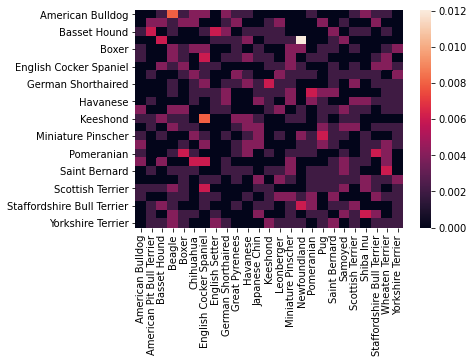

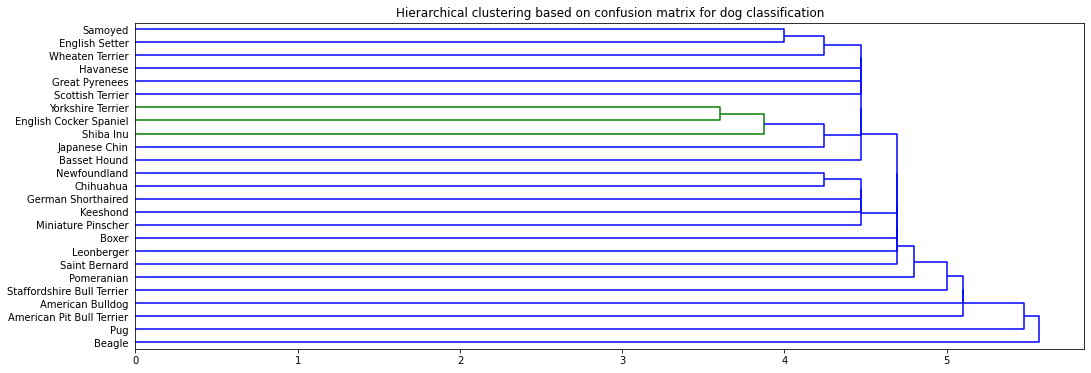

In [ ]:
clustering_from_conf(vgg_model_dogs, test_data_dogs, 'dog')

#### Mobile_Net Model

In [ ]:
# Loading model
mobile_net_model_dogs = load_model('mobile_net_dog_breed_classifier')

In [ ]:
clustering_from_conf(mobile_net_model_dogs, test_data_dogs, 'dog')

### Multi-Class modeling (Cat-breeds):

#### Vgg Model

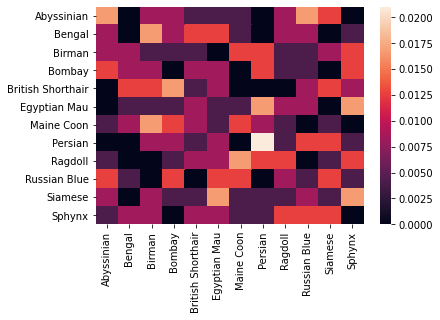

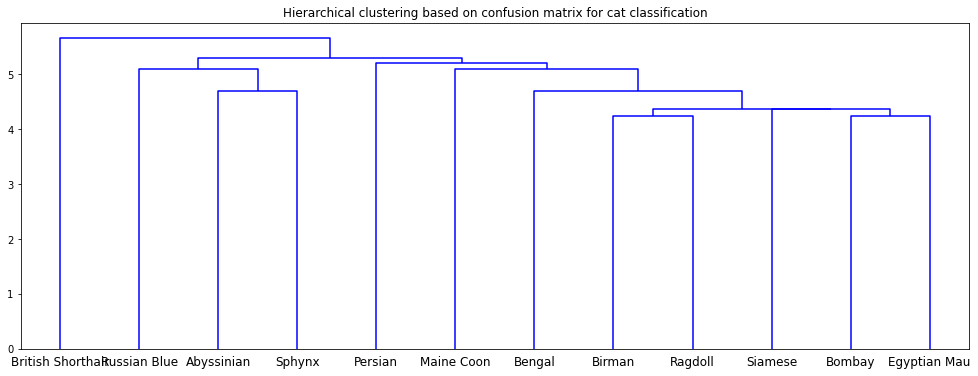

In [ ]:
import numpy as np
clustering_from_conf(vgg_model_cats, test_data_cats, 'cat')

#### Mobile_Net Model